In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

x_trains = [
    np.array(x_train[y_train != i], dtype = 'float64') for i in range(10)
]
y_trains = [
    np.array(y_train[y_train != i], dtype = 'float64') for i in range(10)
]

def build_model():

    input_layer = tf.keras.layers.Input(x_train.shape[1:])
    x = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)

    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    
    ood_x = tf.keras.layers.Dense(10, activation = 'relu')(x)
    
    regular_output = tf.keras.layers.Dense(10, activation = 'softmax')(x)
    
    ood_x = tf.keras.layers.Concatenate()([ood_x, regular_output])
    ood_output = tf.keras.layers.Dense(28*28, activation = 'sigmoid')(ood_x)
    
    model = tf.keras.models.Model(input_layer, [regular_output, ood_output])
    model.compile(loss = ['sparse_categorical_crossentropy', 'cosine_similarity'], optimizer = 'adam')
    return model

def determine_cutoff(similarities):
    return similarities.mean() + 1*similarities.std()

In [3]:
def run_experiment(ood_value):
    
    print(f'Running Experiment for OOD value {ood_value}')
    callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3)
    model = build_model()
    model.fit(x_trains[ood_value], [y_trains[ood_value], x_trains[ood_value].reshape((x_trains[ood_value].shape[0], -1))], batch_size = 512, epochs = 100, callbacks = [callback], validation_split = 0.2, verbose = 0)
    
    probs, autoencode = model.predict(x_trains[ood_value])
    train_similarities = tf.keras.losses.cosine_similarity(
        np.array(x_trains[ood_value].reshape(x_trains[ood_value].shape[0], -1), dtype = 'float32'),
        np.array(autoencode, dtype = 'float32')
    ).numpy()
    cutoff = determine_cutoff(train_similarities)
    
    probs, autoencode = model.predict(x_test)
    probs = probs.argmax(axis = 1)
    autoencode = autoencode.reshape((autoencode.shape[0], 28, 28))
    similarities = tf.keras.losses.cosine_similarity(np.array(x_test.reshape(x_test.shape[0], -1), dtype = 'float32'), np.array(autoencode.reshape(autoencode.shape[0], -1), dtype = 'float32'))
    
    print(classification_report(y_test, probs))
    
    for i in range(20):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(x_test[i], cmap = 'Greys')
        ax2.imshow(autoencode[i], cmap = 'Greys')
        ax2.set_title(f'Similarity: {similarities[i]}')
        if y_test[i] == ood_value:
            ax1.set_title(f'Out of Domain, Trusted: {similarities[i] <= cutoff}', fontsize = 'small')
        else:
            ax1.set_title(f'In Domain, Trusted: {similarities[i] <= cutoff}', fontsize = 'small')
        plt.show()
    
    plt.hist(similarities[y_test != ood_value].numpy())
    plt.title('Similarity Distribution for ID test data', fontsize = 'x-large')
    plt.show()
        
    plt.hist(similarities[y_test == ood_value].numpy())
    plt.title('Similarity Distribution for OOD test data', fontsize = 'x-large')
    plt.show()
    
    print('OOD Detections: (True Indicates Trusted)')
    print(pd.Series(similarities[y_test == ood_value] <= cutoff).value_counts())
    print('\n')
    
    print('ID Detections: (True Indicates Trusted)')
    print(pd.Series(similarities[y_test != ood_value] <= cutoff).value_counts())

Running Experiment for OOD value 0
Metal device set to: Apple M1


2021-12-09 11:19:59.167597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-09 11:19:59.167713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-09 11:19:59.629752: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-09 11:19:59.800183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:01.443871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:06.028404: I tensorflow/core/grappler/o

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.98      0.97      0.97      1000
           2       0.79      0.73      0.76      1000
           3       0.79      0.91      0.84      1000
           4       0.78      0.77      0.77      1000
           5       0.96      0.96      0.96      1000
           6       0.41      0.78      0.54      1000
           7       0.92      0.97      0.94      1000
           8       0.93      0.98      0.95      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.80     10000
   macro avg       0.75      0.80      0.77     10000
weighted avg       0.75      0.80      0.77     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


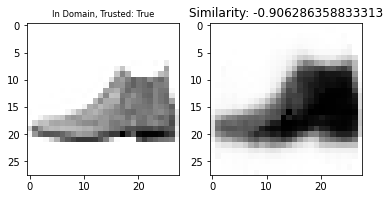

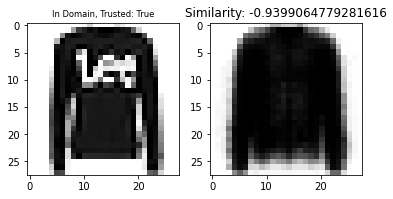

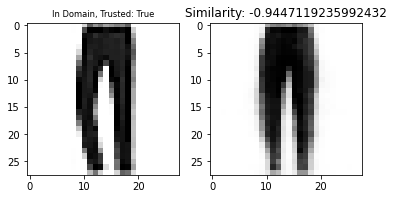

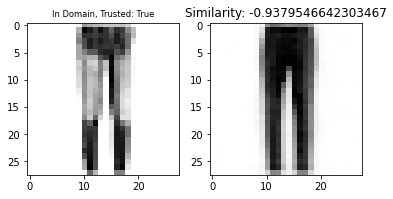

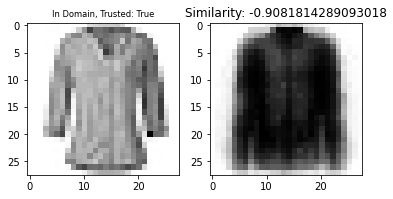

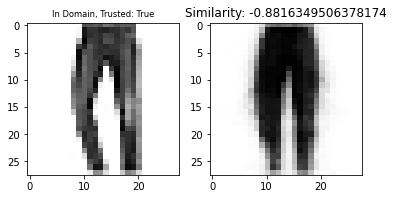

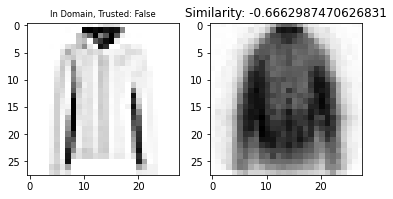

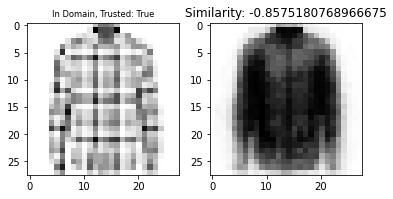

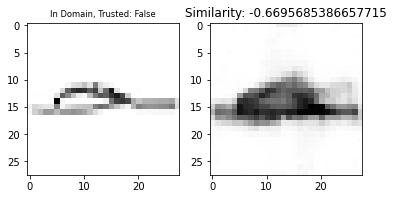

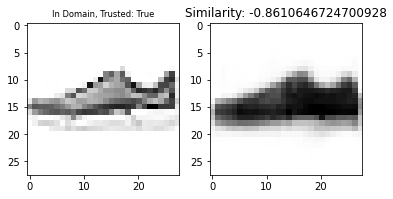

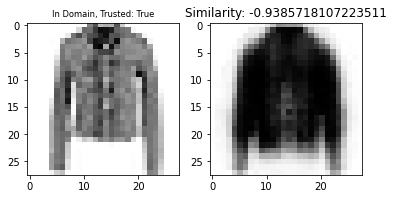

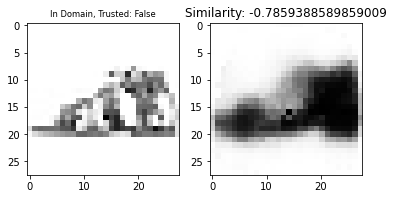

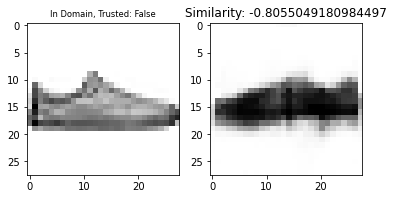

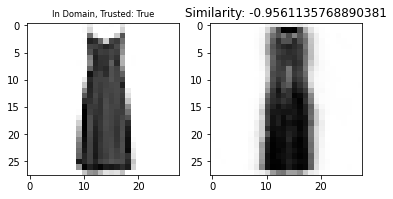

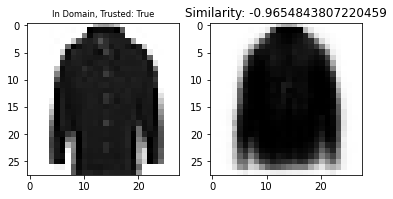

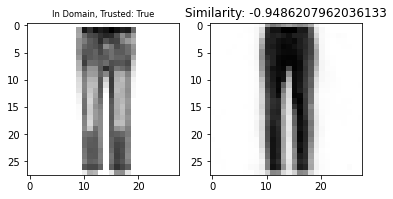

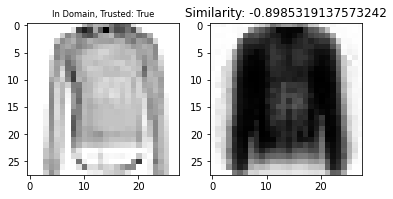

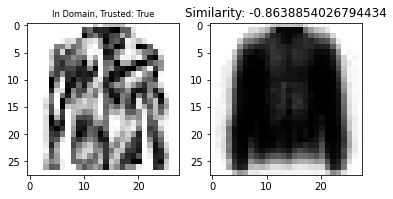

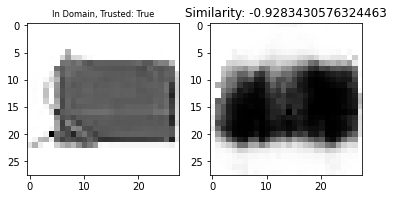

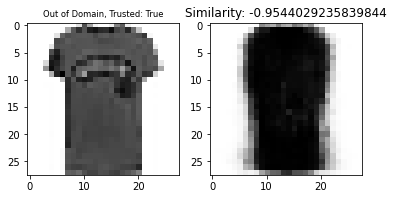

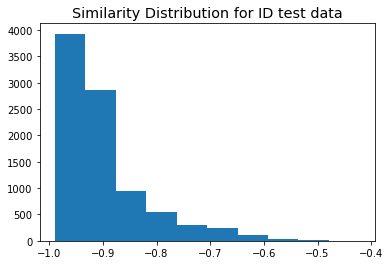

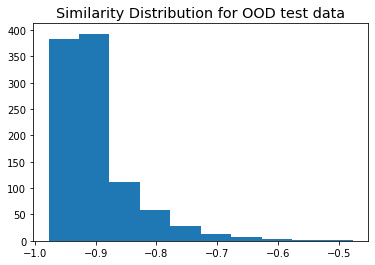

OOD Detections: (True Indicates Trusted)
True     909
False     91
dtype: int64


ID Detections: (True Indicates Trusted)
True     7744
False    1256
dtype: int64


In [4]:
run_experiment(0)

Running Experiment for OOD value 1


2021-12-09 11:20:11.491590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:12.358697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:16.425012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1000
           1       0.00      0.00      0.00      1000
           2       0.85      0.60      0.70      1000
           3       0.49      0.87      0.63      1000
           4       0.62      0.92      0.74      1000
           5       0.97      0.94      0.95      1000
           6       0.68      0.62      0.65      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.76     10000
   macro avg       0.72      0.76      0.73     10000
weighted avg       0.72      0.76      0.73     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


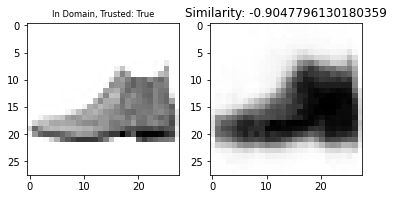

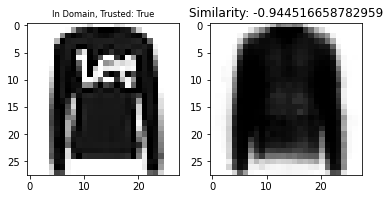

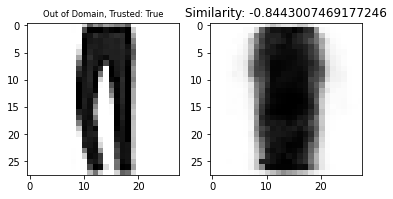

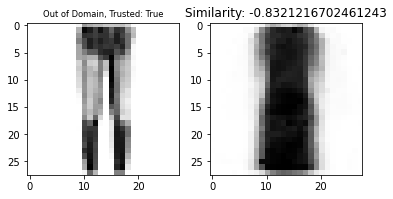

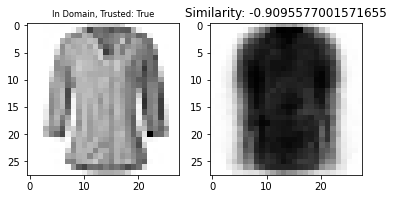

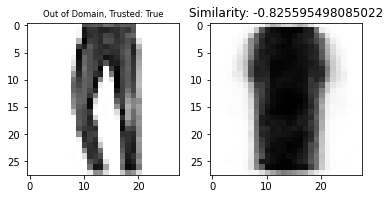

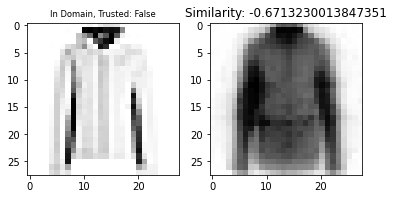

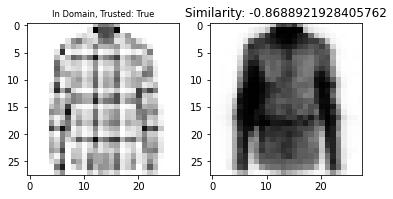

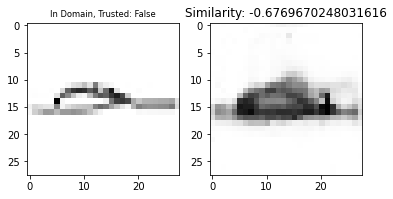

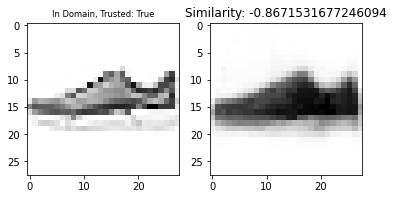

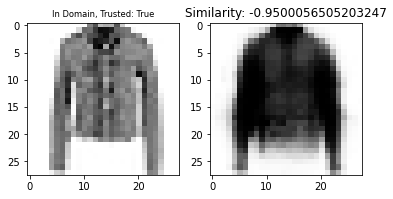

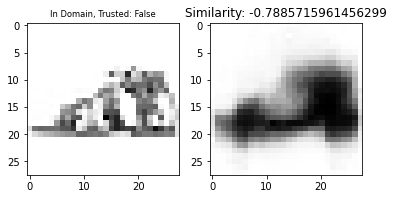

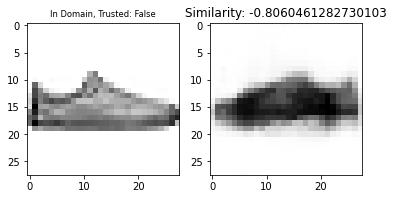

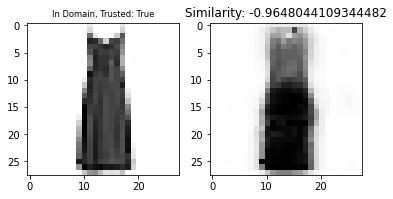

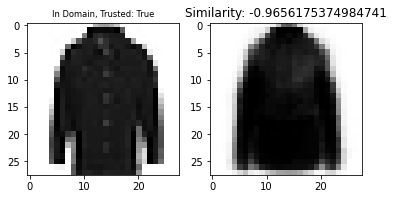

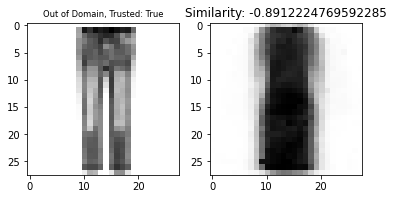

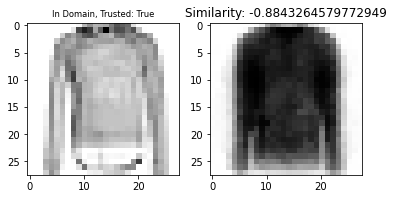

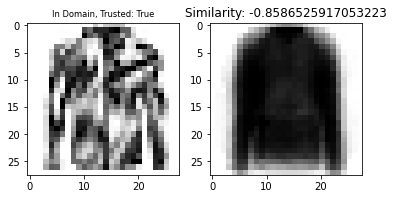

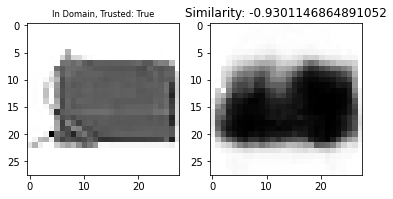

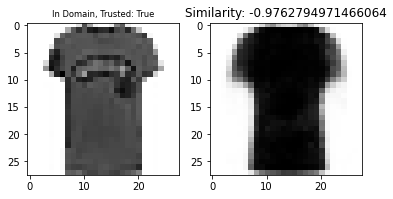

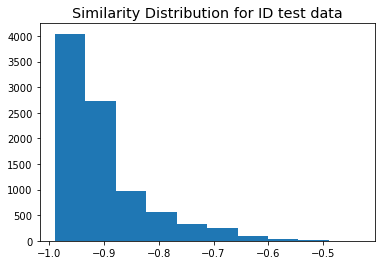

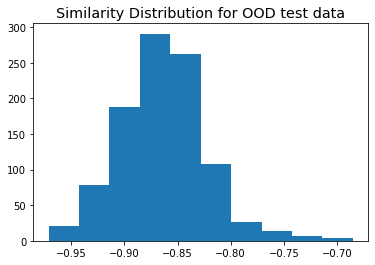

OOD Detections: (True Indicates Trusted)
True     874
False    126
dtype: int64


ID Detections: (True Indicates Trusted)
True     7726
False    1274
dtype: int64


In [5]:
run_experiment(1)

Running Experiment for OOD value 2


2021-12-09 11:20:20.877828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:21.694138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:25.684725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1000
           1       0.99      0.95      0.97      1000
           2       0.00      0.00      0.00      1000
           3       0.78      0.94      0.85      1000
           4       0.65      0.79      0.71      1000
           5       0.93      0.96      0.95      1000
           6       0.46      0.74      0.57      1000
           7       0.94      0.93      0.93      1000
           8       0.95      0.96      0.96      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.80     10000
   macro avg       0.75      0.80      0.77     10000
weighted avg       0.75      0.80      0.77     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


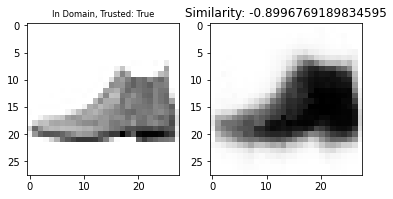

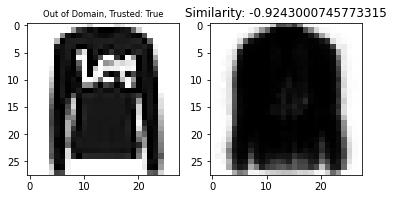

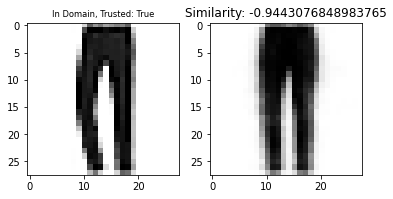

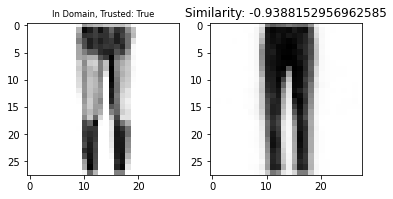

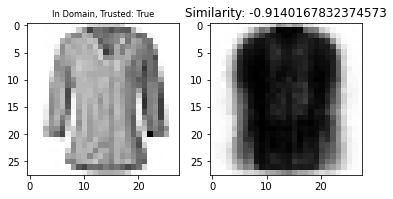

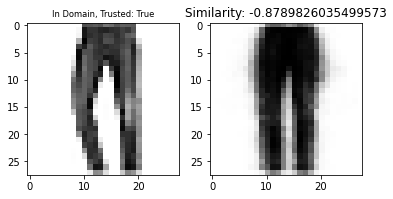

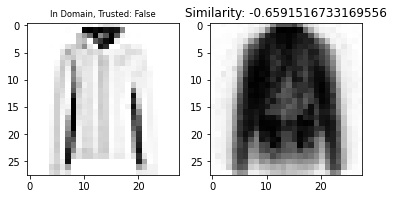

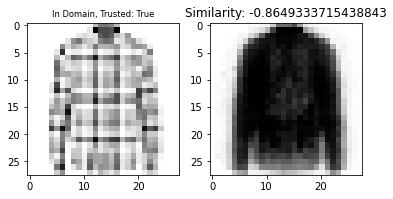

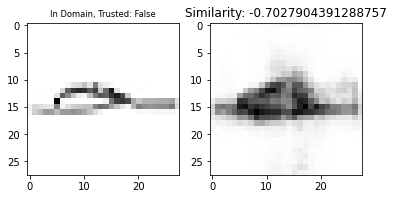

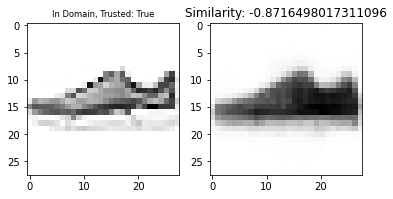

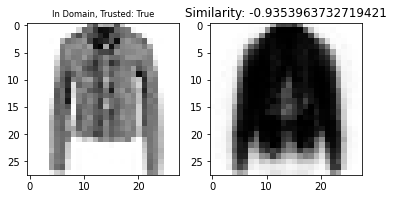

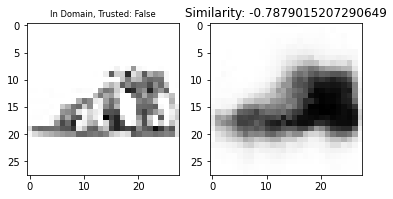

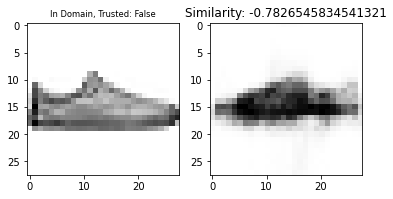

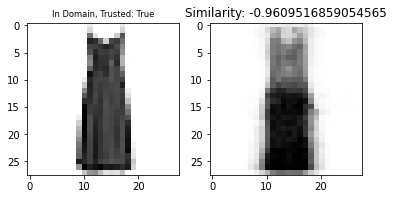

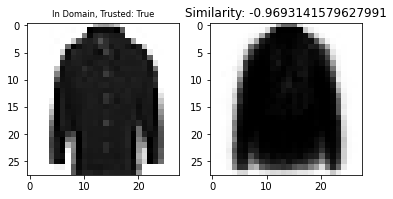

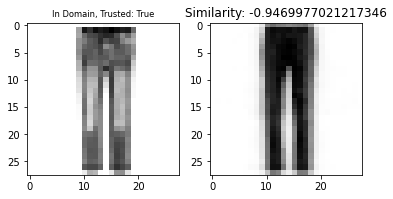

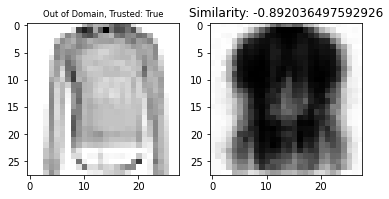

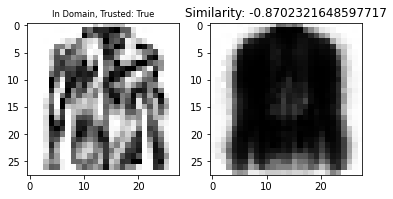

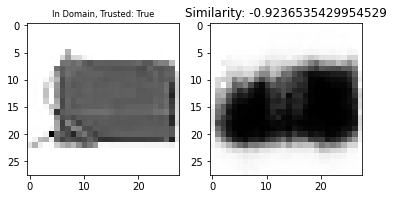

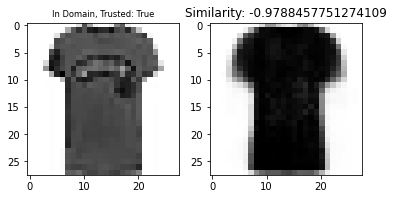

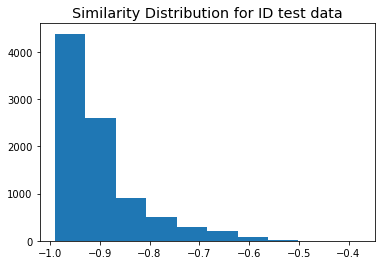

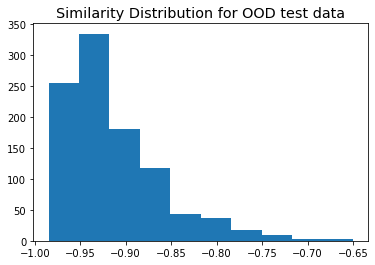

OOD Detections: (True Indicates Trusted)
True     930
False     70
dtype: int64


ID Detections: (True Indicates Trusted)
True     7768
False    1232
dtype: int64


In [6]:
run_experiment(2)

Running Experiment for OOD value 3


2021-12-09 11:20:30.222045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:31.053073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:35.739655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.54      0.88      0.67      1000
           1       0.83      0.97      0.90      1000
           2       0.77      0.77      0.77      1000
           3       0.00      0.00      0.00      1000
           4       0.74      0.76      0.75      1000
           5       0.93      0.97      0.95      1000
           6       0.59      0.69      0.63      1000
           7       0.93      0.93      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.79     10000
   macro avg       0.73      0.79      0.75     10000
weighted avg       0.73      0.79      0.75     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


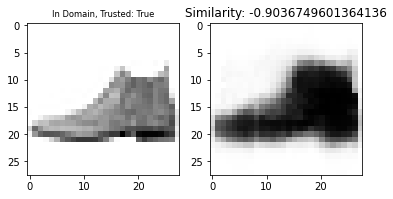

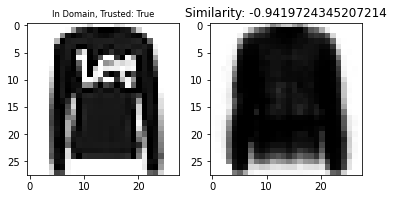

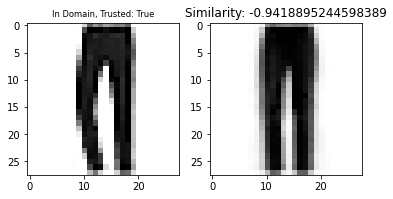

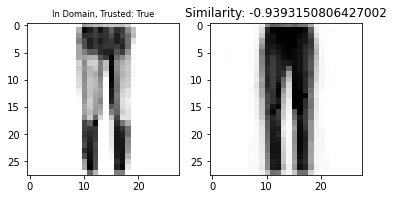

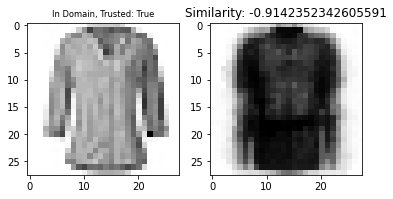

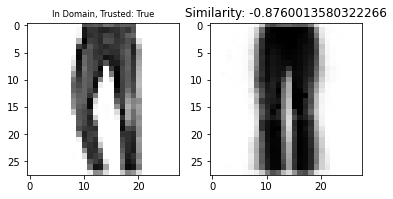

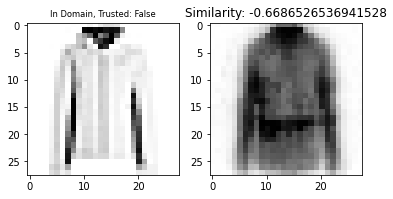

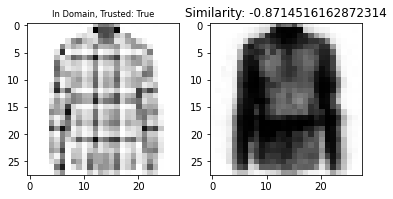

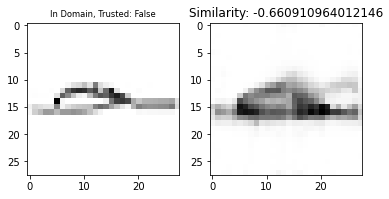

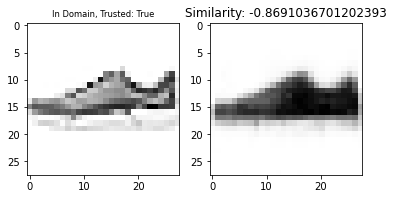

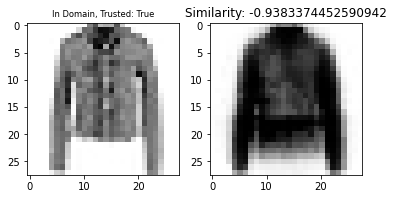

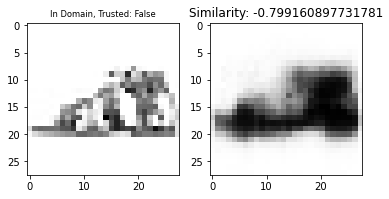

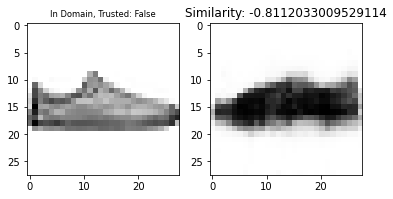

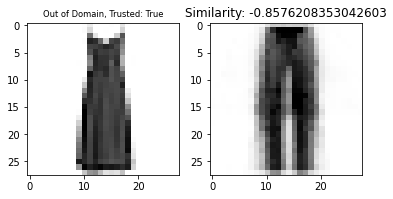

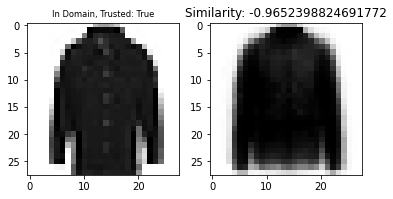

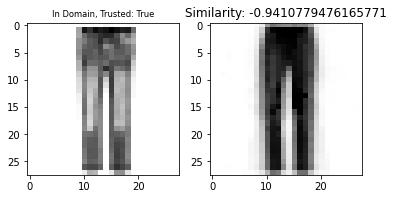

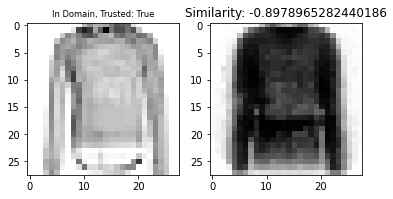

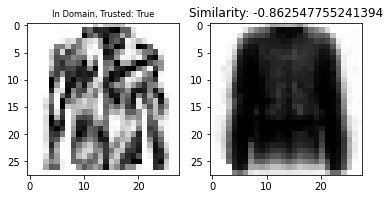

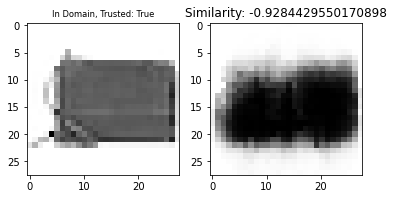

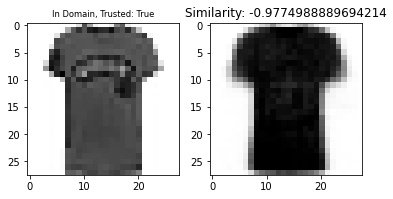

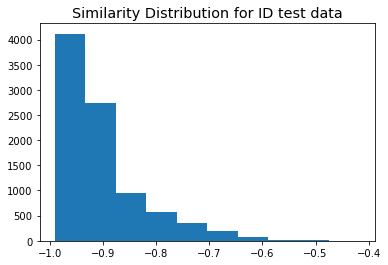

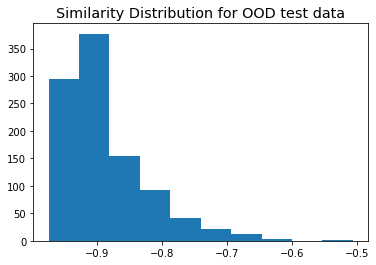

OOD Detections: (True Indicates Trusted)
True     848
False    152
dtype: int64


ID Detections: (True Indicates Trusted)
True     7735
False    1265
dtype: int64


In [7]:
run_experiment(3)

Running Experiment for OOD value 4


2021-12-09 11:20:40.197919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:41.027066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:46.368657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.99      0.96      0.97      1000
           2       0.63      0.77      0.70      1000
           3       0.80      0.92      0.85      1000
           4       0.00      0.00      0.00      1000
           5       0.96      0.96      0.96      1000
           6       0.46      0.74      0.57      1000
           7       0.95      0.92      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.81     10000
   macro avg       0.75      0.81      0.77     10000
weighted avg       0.75      0.81      0.77     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


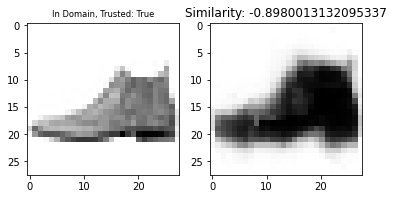

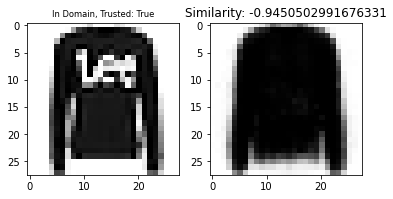

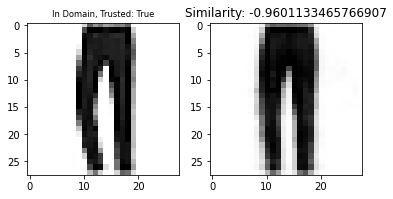

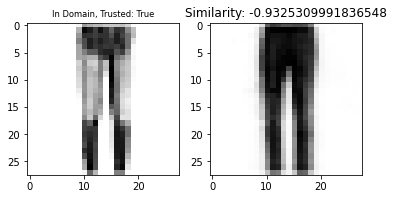

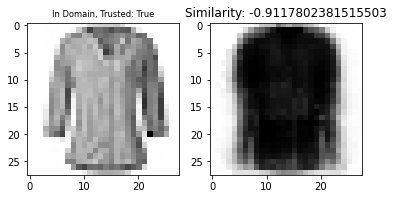

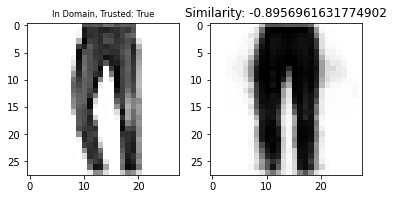

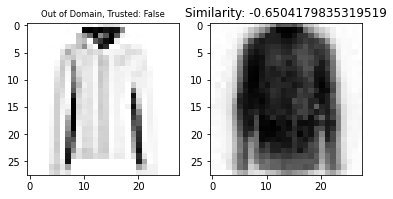

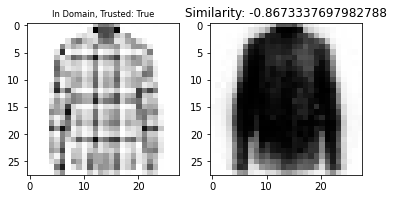

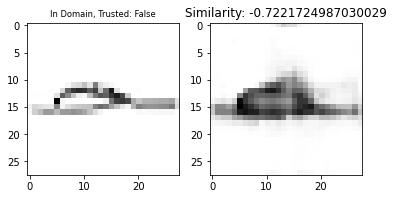

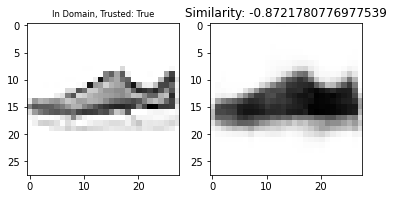

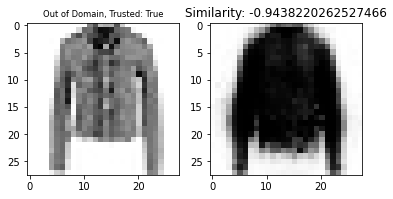

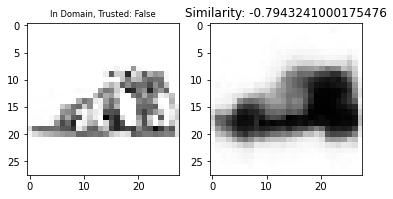

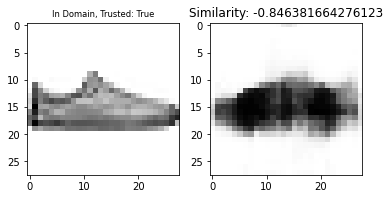

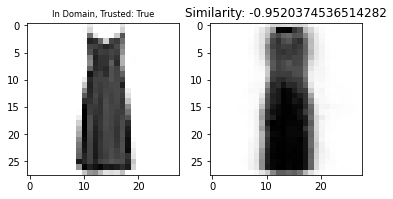

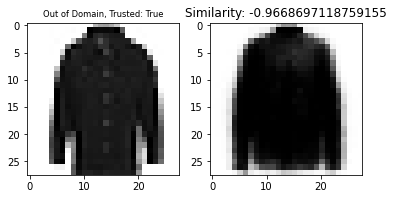

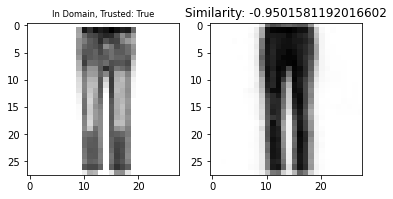

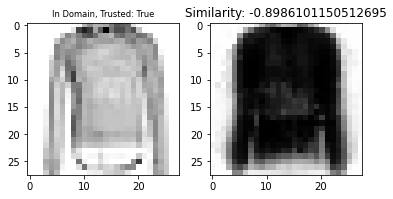

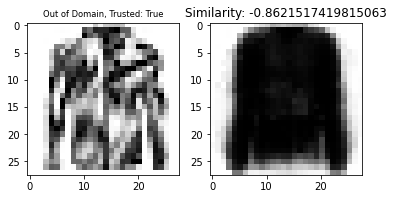

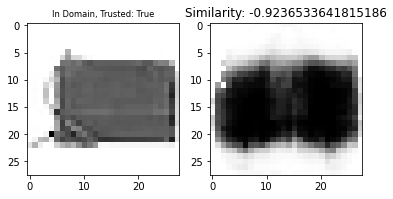

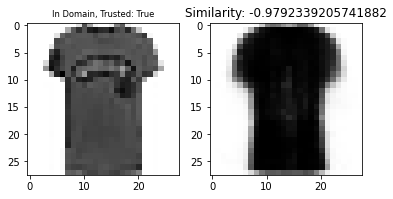

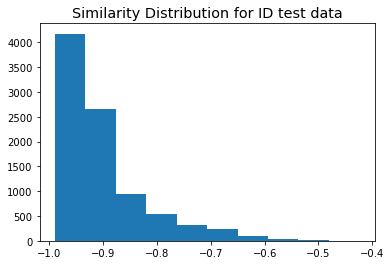

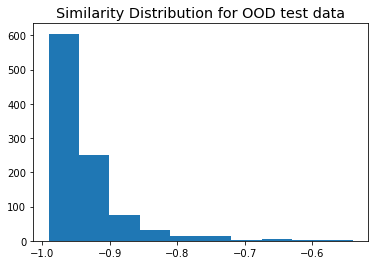

OOD Detections: (True Indicates Trusted)
True     959
False     41
dtype: int64


ID Detections: (True Indicates Trusted)
True     7752
False    1248
dtype: int64


In [8]:
run_experiment(4)

Running Experiment for OOD value 5


2021-12-09 11:20:50.951396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:51.806834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:20:57.477582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.79      0.79      1000
           3       0.84      0.91      0.87      1000
           4       0.81      0.75      0.78      1000
           5       0.00      0.00      0.00      1000
           6       0.67      0.72      0.69      1000
           7       0.61      0.98      0.75      1000
           8       0.93      0.97      0.95      1000
           9       0.70      0.94      0.80      1000

    accuracy                           0.78     10000
   macro avg       0.72      0.78      0.74     10000
weighted avg       0.72      0.78      0.74     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


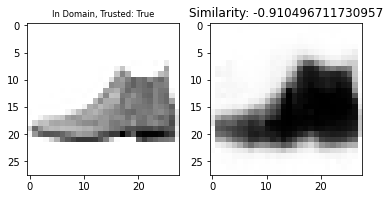

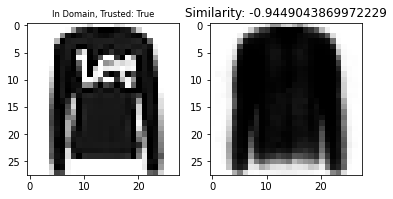

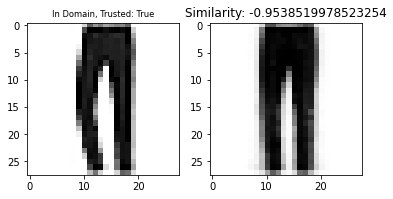

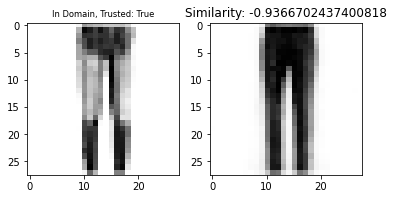

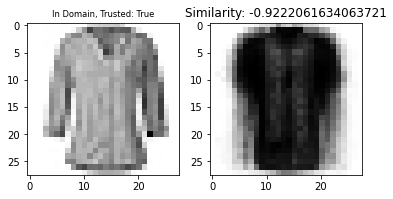

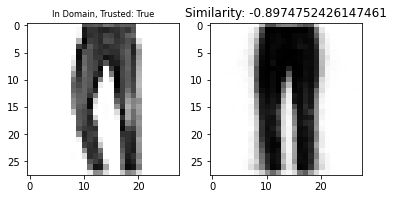

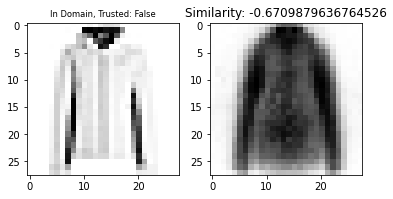

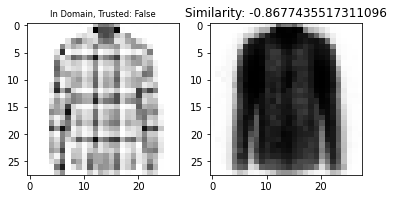

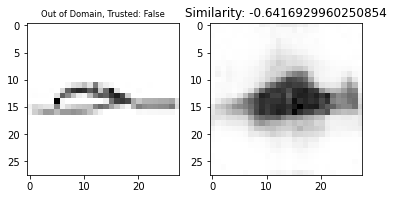

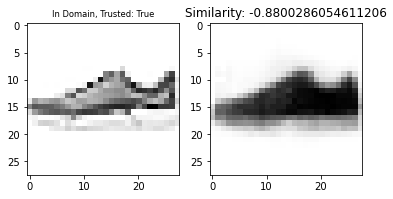

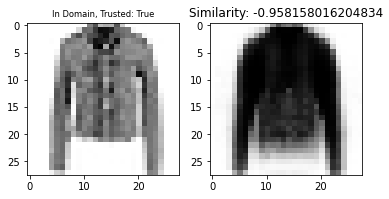

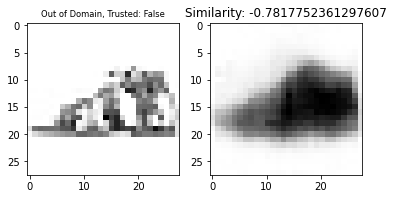

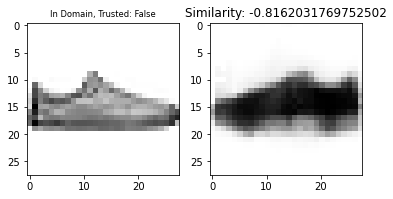

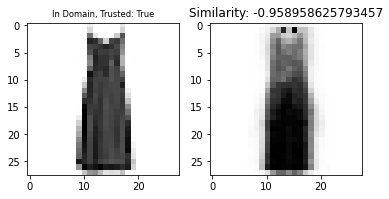

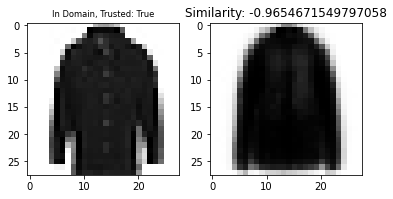

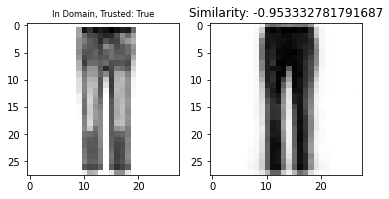

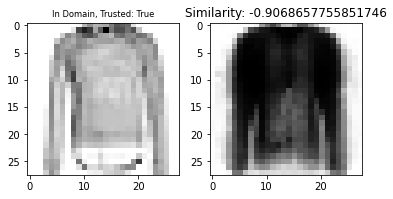

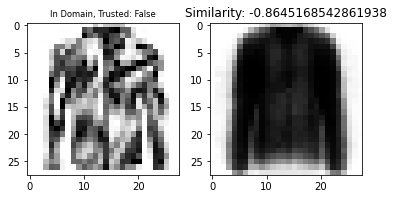

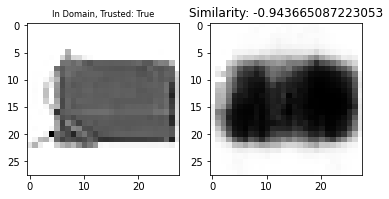

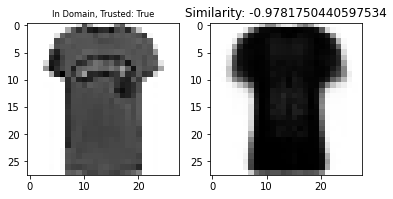

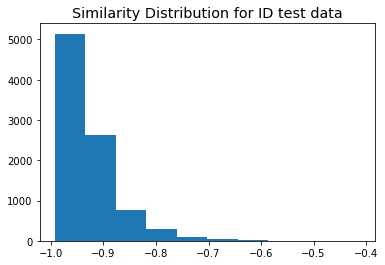

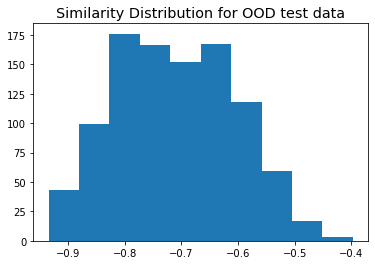

OOD Detections: (True Indicates Trusted)
False    941
True      59
dtype: int64


ID Detections: (True Indicates Trusted)
True     7893
False    1107
dtype: int64


In [9]:
run_experiment(5)

Running Experiment for OOD value 6


2021-12-09 11:21:02.215955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:03.076788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:09.378393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1000
           1       0.99      0.97      0.98      1000
           2       0.70      0.81      0.75      1000
           3       0.86      0.89      0.87      1000
           4       0.59      0.88      0.70      1000
           5       0.96      0.96      0.96      1000
           6       0.00      0.00      0.00      1000
           7       0.88      0.97      0.92      1000
           8       0.91      0.98      0.94      1000
           9       0.98      0.89      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.76      0.82      0.79     10000
weighted avg       0.76      0.82      0.79     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


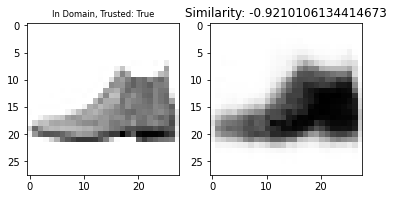

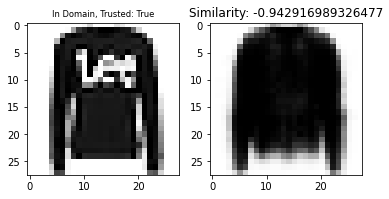

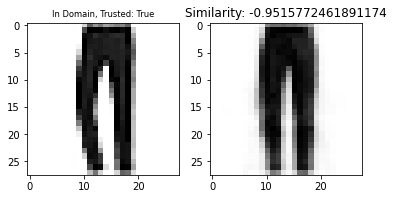

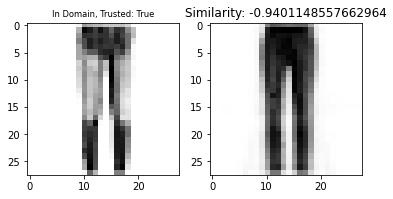

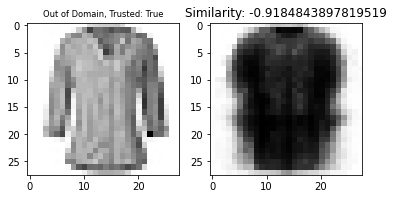

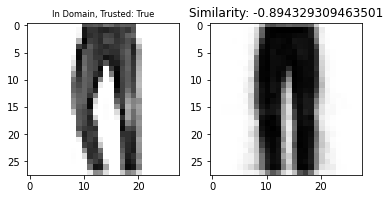

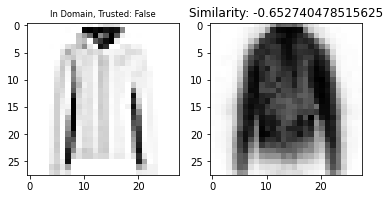

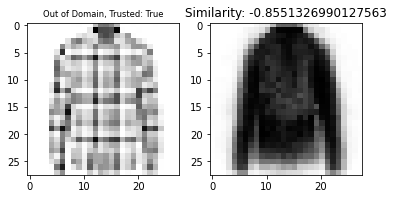

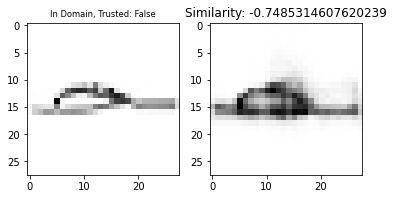

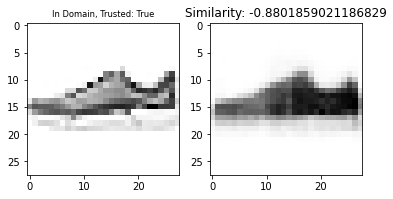

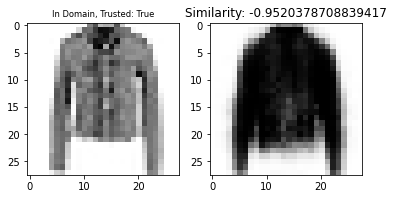

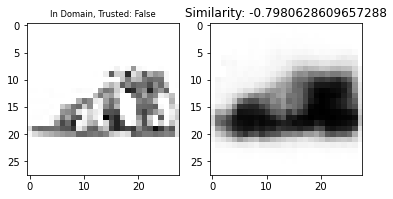

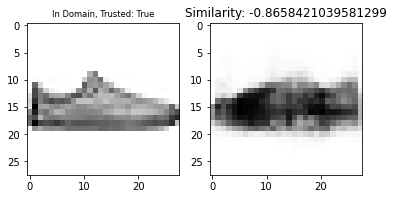

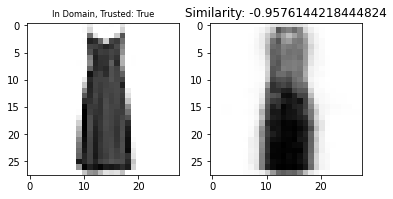

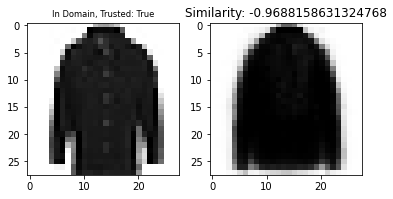

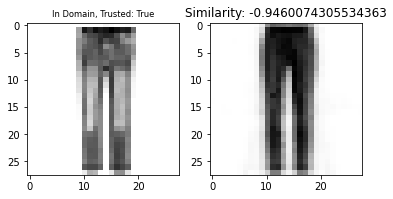

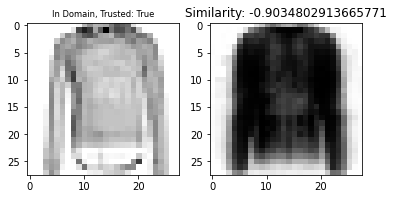

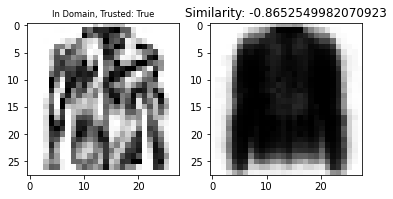

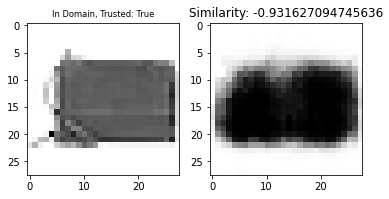

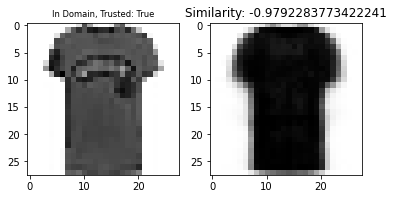

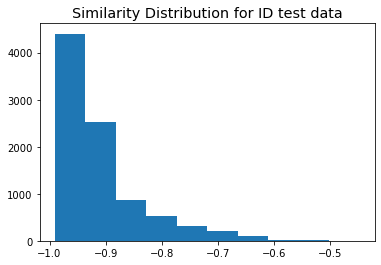

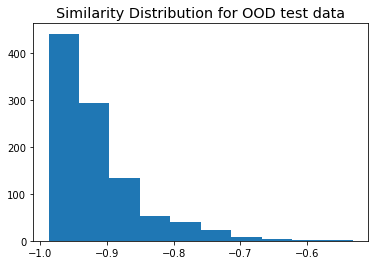

OOD Detections: (True Indicates Trusted)
True     889
False    111
dtype: int64


ID Detections: (True Indicates Trusted)
True     7746
False    1254
dtype: int64


In [10]:
run_experiment(6)

Running Experiment for OOD value 7


2021-12-09 11:21:14.140147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:15.012646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:21.137093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.81      0.75      0.78      1000
           3       0.80      0.93      0.86      1000
           4       0.79      0.83      0.81      1000
           5       0.65      0.97      0.78      1000
           6       0.70      0.67      0.68      1000
           7       0.00      0.00      0.00      1000
           8       0.91      0.96      0.94      1000
           9       0.69      0.99      0.81      1000

    accuracy                           0.79     10000
   macro avg       0.72      0.79      0.74     10000
weighted avg       0.72      0.79      0.74     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


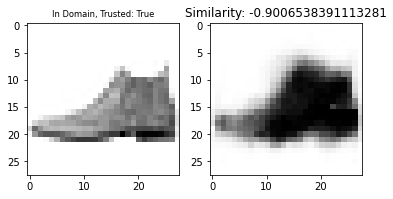

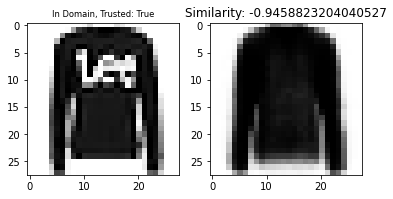

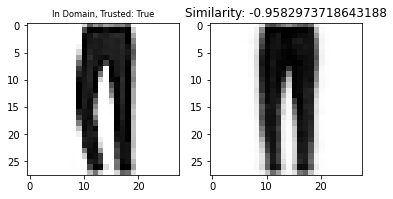

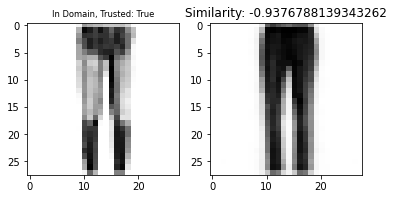

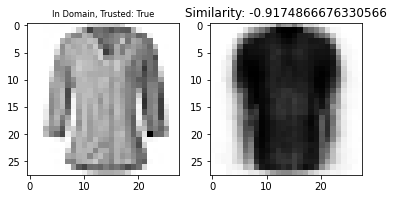

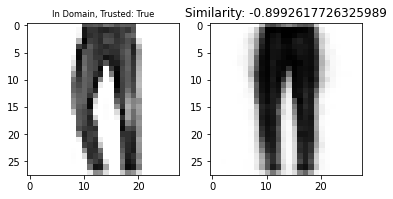

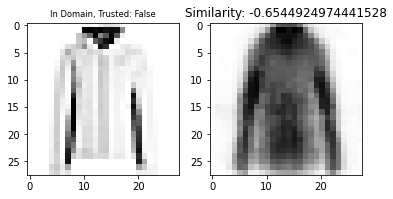

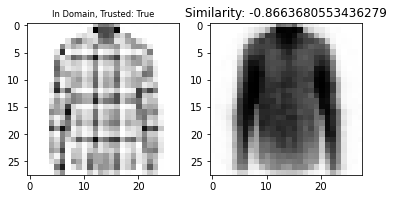

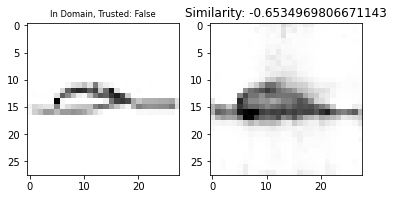

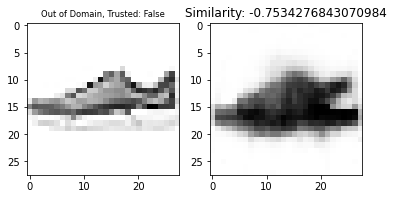

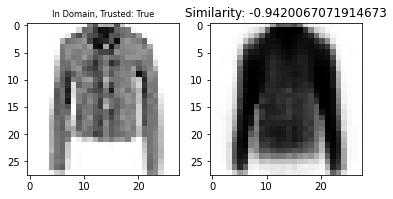

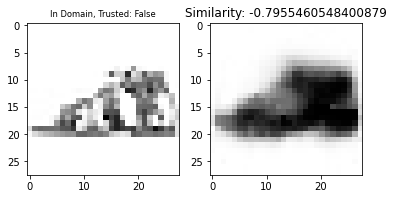

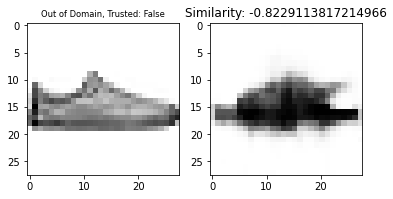

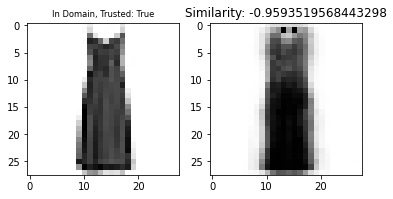

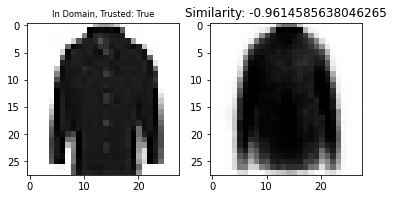

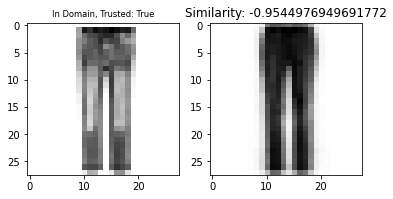

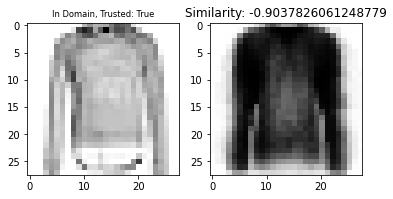

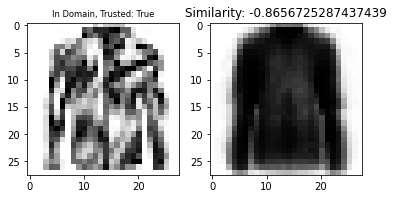

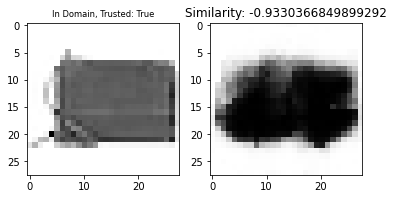

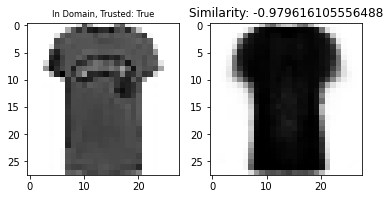

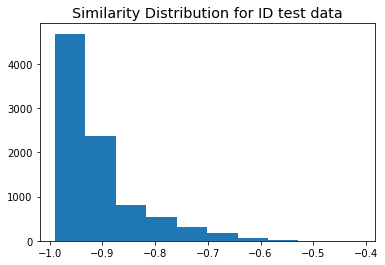

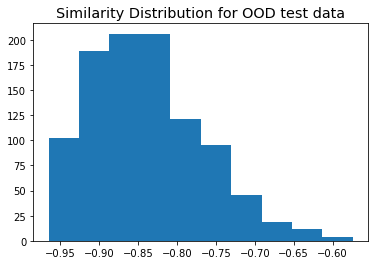

OOD Detections: (True Indicates Trusted)
True     600
False    400
dtype: int64


ID Detections: (True Indicates Trusted)
True     7704
False    1296
dtype: int64


In [11]:
run_experiment(7)

Running Experiment for OOD value 8


2021-12-09 11:21:25.791082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:26.666613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:32.094487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1000
           1       0.97      0.97      0.97      1000
           2       0.72      0.73      0.73      1000
           3       0.82      0.84      0.83      1000
           4       0.58      0.91      0.71      1000
           5       0.78      0.98      0.86      1000
           6       0.51      0.60      0.55      1000
           7       0.92      0.91      0.91      1000
           8       0.00      0.00      0.00      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.77     10000
   macro avg       0.70      0.77      0.73     10000
weighted avg       0.70      0.77      0.73     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


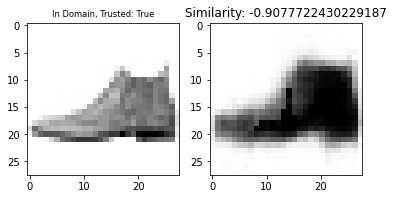

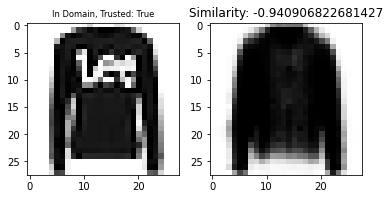

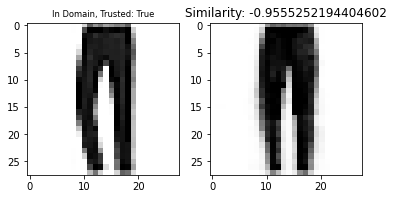

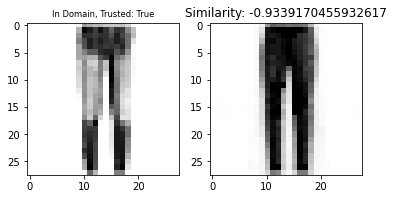

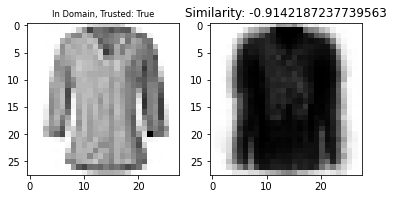

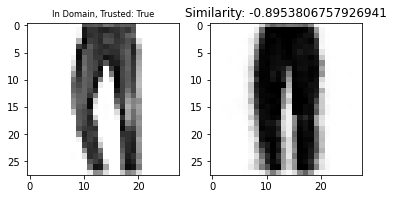

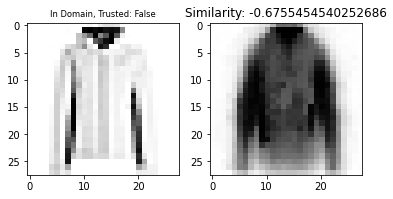

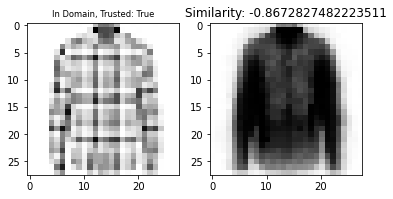

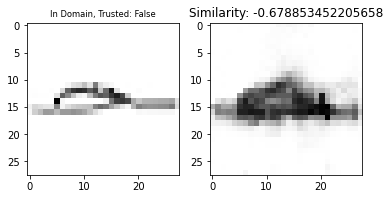

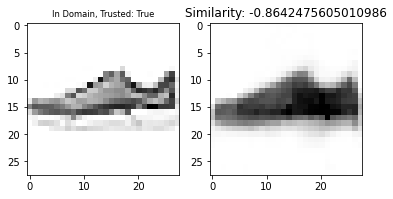

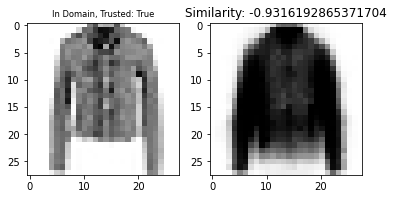

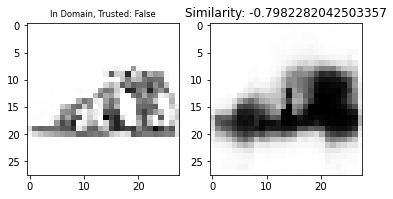

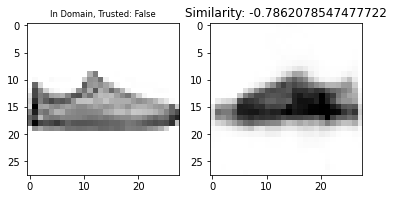

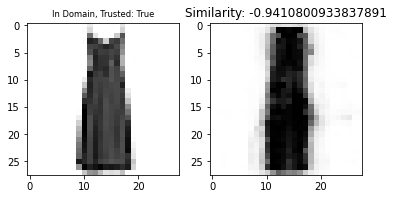

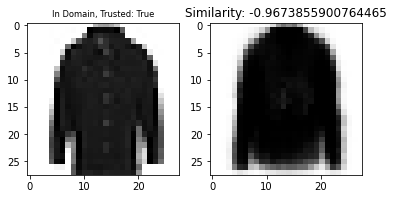

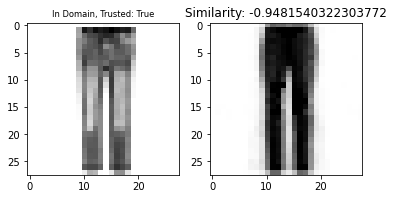

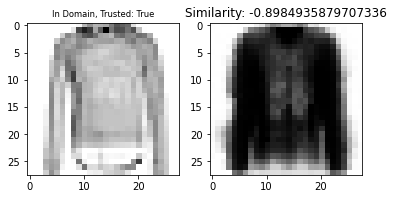

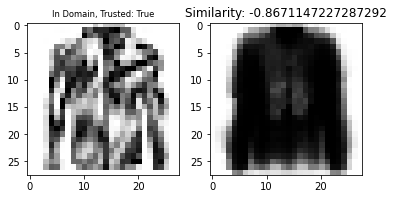

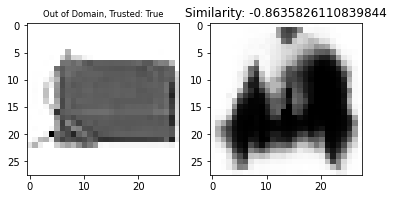

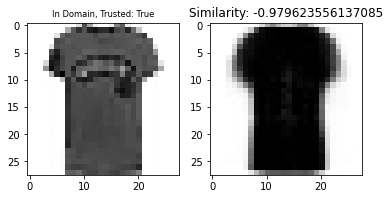

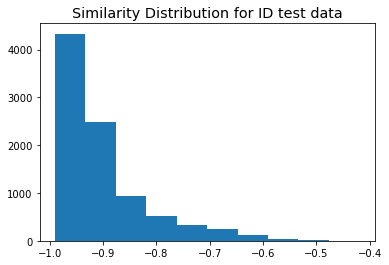

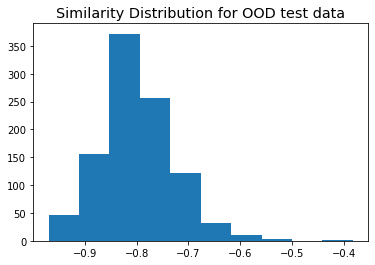

OOD Detections: (True Indicates Trusted)
False    613
True     387
dtype: int64


ID Detections: (True Indicates Trusted)
True     7743
False    1257
dtype: int64


In [12]:
run_experiment(8)

Running Experiment for OOD value 9


2021-12-09 11:21:36.952324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:37.883889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-09 11:21:43.395106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1000
           1       0.97      0.97      0.97      1000
           2       0.84      0.68      0.75      1000
           3       0.83      0.89      0.86      1000
           4       0.72      0.87      0.79      1000
           5       0.70      0.93      0.80      1000
           6       0.70      0.68      0.69      1000
           7       0.59      0.99      0.74      1000
           8       0.95      0.98      0.97      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.78     10000
   macro avg       0.72      0.78      0.74     10000
weighted avg       0.72      0.78      0.74     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


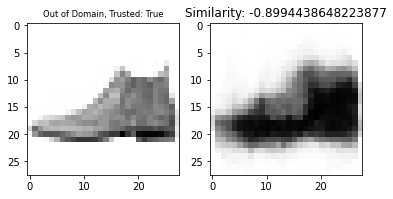

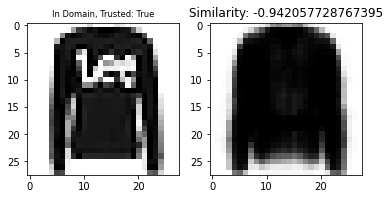

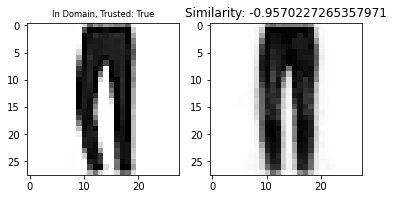

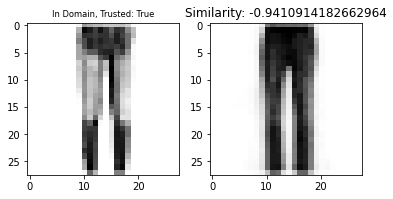

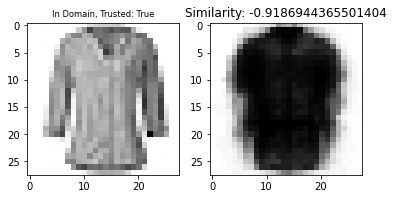

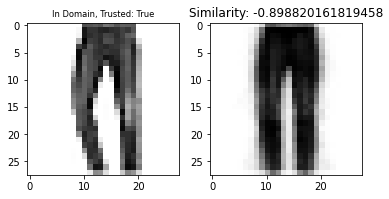

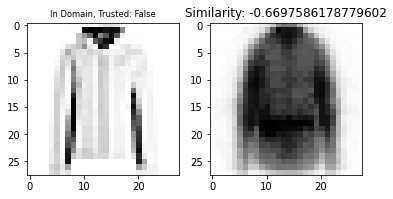

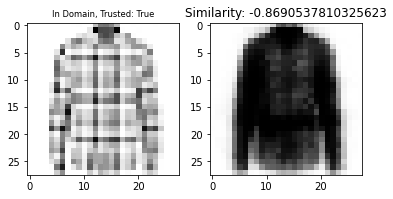

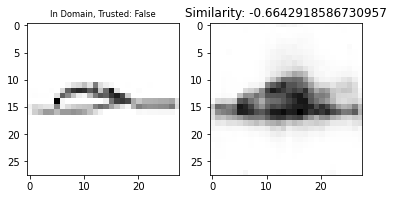

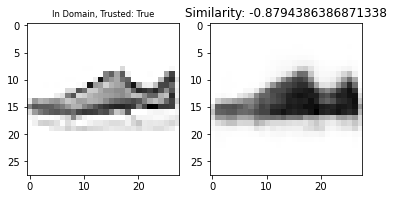

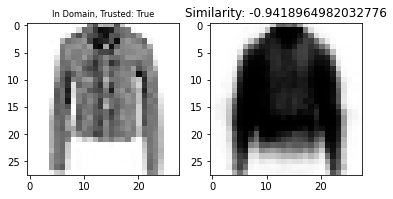

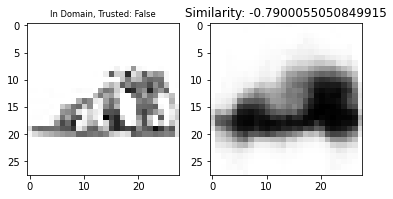

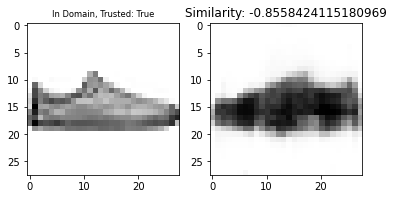

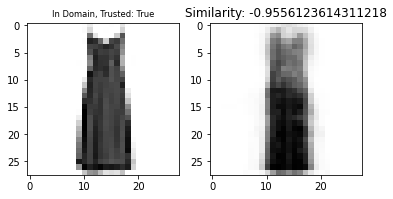

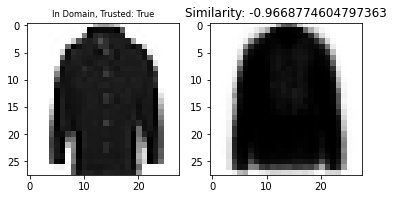

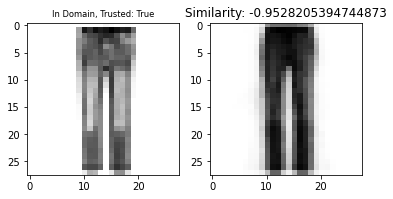

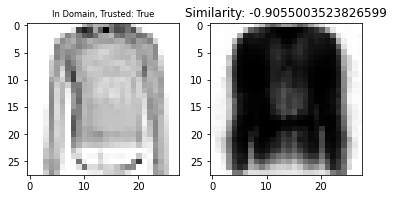

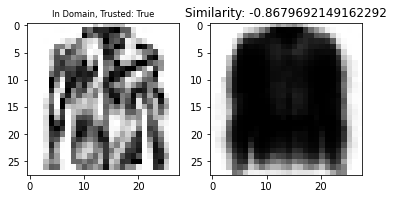

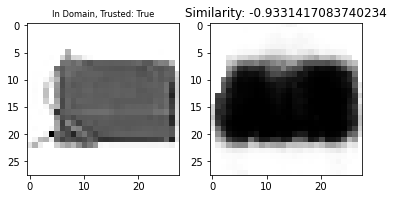

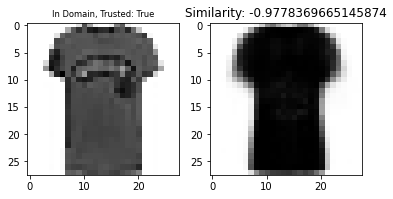

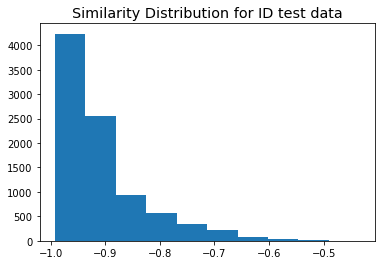

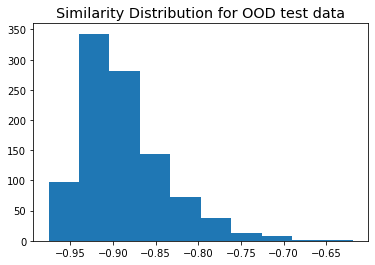

OOD Detections: (True Indicates Trusted)
True     882
False    118
dtype: int64


ID Detections: (True Indicates Trusted)
True     7722
False    1278
dtype: int64


In [13]:
run_experiment(9)